<a href="https://colab.research.google.com/github/CagdasCankaya/Automatic-Parasite-Detection_in_Microscopic_Cell_Images_Using_CNN/blob/main/malaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf #models
import numpy as np #math computing
import matplotlib.pyplot as plt #plotting chart

import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten,InputLayer,RandomFlip,RandomRotation,BatchNormalization,Input,Dropout
from  tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, BinaryAccuracy, AUC
from tensorflow.keras.losses import MeanSquaredError,Huber,MeanAbsoluteError , BinaryCrossentropy
from tensorflow.keras.callbacks import Callback , CSVLogger , EarlyStopping, LearningRateScheduler
from tensorflow.keras.regularizers import L2,L1
import cv2
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
from google.colab import drive
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True,shuffle_files=False, split= ['train'])


In [ ]:
dataset
for data in dataset[0].take(1):
  print(data)

print()

#dataset = tf.data.Dataset.range(10)
#dataset = dataset.skip(6) [6,7,8,9]
#dataset = dataset.take(6) [0,1,2,3,4,5]
#list(dataset.as_numpy_iterator())


##for data in dataset[0].take(4):
  #print(data)


dataset, dataset_info = tfds.load('malaria', with_info=True,
                                  as_supervised=True,
                                  shuffle_files = True,
                                  split=['train'])

(<tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)



In [ ]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

dataset = tf.data.Dataset.range(10)
print(list(dataset.as_numpy_iterator()))

dataset_size = len(dataset)
train_dataset = dataset.take(int(0.8*dataset_size))
print(list(train_dataset.as_numpy_iterator()))


val_test_dataset = dataset.skip(int(train_ratio*dataset_size))
val_dataset = val_test_dataset.take(int(val_ratio*dataset_size))
print(list(val_dataset.as_numpy_iterator()))


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7]
[8]


**Dataset visualization**

In [ ]:
def splits(dataset, train_ratio, val_ratio , test_ratio ):
  dataset_size = len(dataset)
  train_dataset = dataset.take(int(train_ratio*dataset_size))
  val_test_dataset = dataset.skip(int(train_ratio*dataset_size))
  val_dataset = val_test_dataset.take(int(val_ratio*dataset_size))
  test_dataset = val_test_dataset.skip(int(val_ratio*dataset_size))
  return train_dataset,val_dataset,test_dataset

train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1
dataset = tf.data.Dataset.range(10)
train_dataset, val_dataset , test_dataset = splits(dataset,train_ratio,val_ratio,test_ratio)

for i , (image,label) in enumerate(train_dataset.take(6)):
  ax = plt.subplot(2,2,i+1)
  plt.imshow(image)
  plt.title(dataset_info.features)


TypeError: Cannot iterate over a scalar tensor.

**Data processing:**

In [ ]:
IM_SIZE = 224
def resizing(image):
  return tf.image.resize(image,(IM_SIZE,IM_SIZE))


In [ ]:
train_dataset = train_dataset.map(resizing)

NameError: name 'train_dataset' is not defined

In [ ]:
for image,label in train_dataset.take(1):
  print(image,label)


TypeError: Cannot iterate over a scalar tensor.

In [ ]:
model = tf.keras.Sequential([
    InputLayer(input_shape=(60,60,3)),
    Conv2D(filters=6,kernel_size=5,strides=1, padding='valid',activation='sigmoid'),
    BatchNormalization(),
    MaxPool2D(pool_size=2,strides=2),

    Conv2D(filters=16,kernel_size=5,strides=1,padding='valid',activation='sigmoid'),
    BatchNormalization(),
    MaxPool2D(pool_size=2,strides=2),

    Flatten(),
    Dense(128, activation = "sigmoid"),
    BatchNormalization(),
    Dense(128, activation = "sigmoid"),
    BatchNormalization(),
    Dense(1, activation = "sigmoid"),


])

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 56, 6)         456       
                                                                 
 batch_normalization (Batch  (None, 56, 56, 6)         24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 28, 28, 6)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 16)        2416      
                                                                 
 batch_normalization_1 (Bat  (None, 24, 24, 16)        64        
 chNormalization)                                                
                                                        

In [ ]:
y_true = [0,]
y_pred = [0.8,]
bce = tf.keras.losses.BinaryCrossentropy()
bce(y_true,y_pred)

y_true2 =[0,1,0,0]
y_pred2 = [0.6,0.51,0.94,0]
bce2 = tf.keras.losses.BinaryCrossentropy(from_logits=False)
bce2(y_true2,y_pred2)

model.compile(optimizer=Adam(learning_rate=0.1),
              loss=BinaryCrossentropy(),
              metrics = 'accuracy',)
              #metrics = RootMeanSquaredError())


In [ ]:
#history = model.fit(train_dataset,validation_data =val_dataset,epochs=100,verbose=1)

In [ ]:
def parasite_or_not(x):
  if(x<0.5):
    return str('p')
  else:
    return str('U')


In [ ]:
#for i, (image,label) in enumerate(test_dataset.take(9)):
#  ax = plt.subplot(3,3, i + 1)
#  plt.imshow(image[0])
#  plt.title(str(parasite_or_not(label.numpy()[0]))+ ":" +str(parasite_or_not(model.predict(image)[0][0])))

In [ ]:
class FeatureExtractor(Layer):
  def __init__(self,filters,kernel_size,strides,padding,activation,pool_size):
    super(FeatureExtractor, self).__init__()
    self.conv_1 = Conv2D(filters*2,kernel_size,strides,padding=padding,activation=activation)
    self.batch_1 = BatchNormalization()
    self.pool_1 = MaxPool2D(pool_size,strides=2*strides)

    self.conv_2 = Conv2D(filters*2,kernel_size,strides,padding=padding,activation=activation)
    self.batch_2 = BatchNormalization()
    self.pool_2  = MaxPoll2D(pool_size, strides=2*strides)

    def call(self,x,training):
      x = self.conv_1(x)
      x= self.batch_1(x)
      x = self.pool_1(x)

      x = self.conv_2(x)
      x = self.batch_2(x)
      x = self.pool_2(x)
      return x

func_input = Input(shape=(3,3,3),name="Input image")
x = feature_extractor_seq_model(func_input)

x = Flatten(x)

x = Dense(100,activation="relu")(x)
x = BatchNormalization(x)

x = Dense(10,activation="relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1,activation="sigmoid")(x)


feature_sub_classed = FeatureExtractor(8,3,1,"valid","relu",2)

In [ ]:
class NeuralearnDense(Layer):
  def __init__(self,output_units,activation):
    self.activation = activation
    super(NeuralearnDense,self).__init__()
    self.output_units = output_units

  def build(self,input_features_shape):
    self.weights = self.add_weight((input_features_shape[-1], self.output_units),initializer="random_normal",trainable=True)
    self.biases = self.add_weights((self.output_units,),initializer ="random_normal",trainable=True)

  def call(self,input_features):
    if(self.activation=="relu"):
      return tf.nn.relu(tf.matmul(input_features,self.weights) + self.biases)

    elif(self.activation=="sigmoid"):
      return tf.math.sigmoid(tf.matmul(input_features,self.weights) + self.biases)
    else:
      return tf.matmul(input_features,self.weights) + self.biases






NameError: name 'Layer' is not defined

In [ ]:
metrics = [TruePositives(name='tp'),FalsePositives(name='fp'),TrueNegatives(name='tn'),FalseNegatives(name='fn'),BinaryAccuracy(name='accuracy'),Precision(name='precision'),Recall(name='recall'), AUC(name='auc')]
model.compile(optimizer=Adam(learning_rate=0.01),
              loss=BinaryCrossentropy(),
              metrics=metrics)
model.summary()
history = model.fit()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 56, 6)         456       
                                                                 
 batch_normalization (Batch  (None, 56, 56, 6)         24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 28, 28, 6)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 16)        2416      
                                                                 
 batch_normalization_1 (Bat  (None, 24, 24, 16)        64        
 chNormalization)                                                
                                                        

Text(0.5, 58.7222222222222, 'predicted')

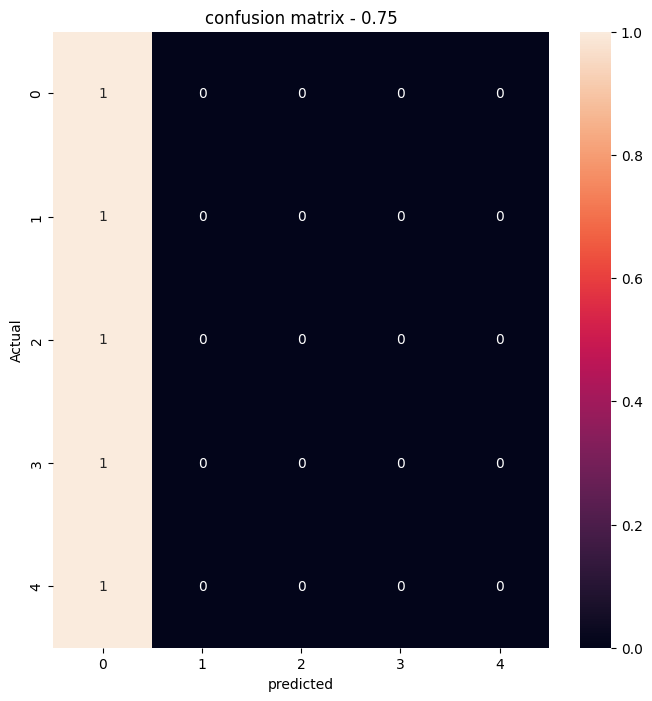

In [ ]:
threshold = 0.23
x = [0,1,2,3,4,5]
y = [1,2,3,4,5]
y_pred = [1 if prob > threshold else 0 for prob in y]

threshold = 0.75
cm = confusion_matrix(y,y_pred )
plt.figure(figsize=(8,8))
sns.heatmap(cm,annot=True,)
plt.title('confusion matrix - {}'.format(threshold))
plt.ylabel('Actual')
plt.xlabel('predicted')


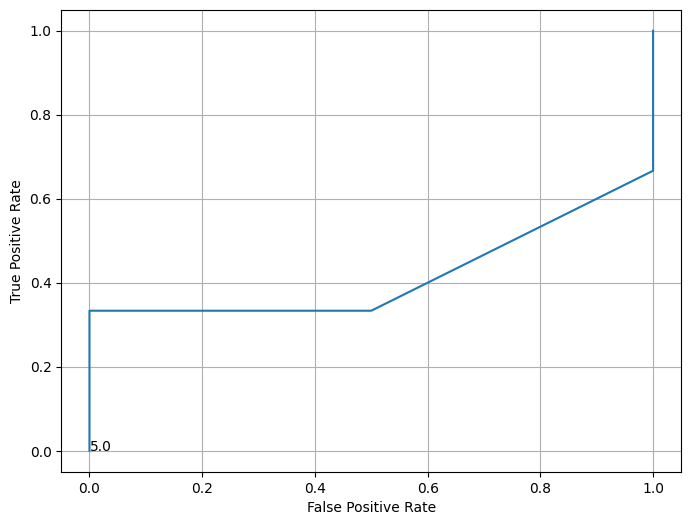

In [ ]:

y = [0, 0, 1, 1, 1]  # Gerçek sınıf etiketleri
y_pred = [2, 0.8, 4, 0.8, 0.7]
fp, tp, thresholds = roc_curve(y, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fp, tp)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
skip = 20
for i in range(0,len(thresholds),skip):
  plt.text(fp[i],tp[i],thresholds[i])
plt.show()

In [ ]:
class LossCallback(Callback):
  def on_epoch_end(self,epoch,logs):
    print("Epoch number {} has loss of {}".format(epoch,logs["loss"]))
  def on_batch_end(self,batch,logs):
    print("Batch number {} loss {}".format(batch,logs))


In [ ]:
csv_callback = CSVLogger('logs.csv',separator=',',append=True)

es_callback = EarlyStopping(
    monitor='val_loss',min_delta=0,patience=0,verbose=0,model='auto',baseline=None,restore_best_weights=False)


TypeError: EarlyStopping.__init__() got an unexpected keyword argument 'model'

In [ ]:
def scheduler(epoch,lr):
  if epoch<10:
    return lr
  else:
    return lr*tf.math.exp(-0.1)
scheduler_callback=LearningRateScheduler(scheduler,verbose=1)

In [ ]:
def augment(image,label):
  imaga,label = reszie_rescale(imaga,label)

  image = tf.image.rot90(image)
  image = tf.image.flip_left_right(image)

  return image,label

augmented_layers = tf.keras.Sequential([
    RandomRotation(factor=(0.25,0.2501),),
    RandomFlip(mode='horizontal',),
])

def augmented_layer(image,label):
  return augment_layers(image,training=True),label


  BATCH_SIZE = 32
  train_dataset = (
      train_dataset.shoffle(buffer_size=8,reshuffle_each_iteration=True).map(augment_layer).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
  )

  val_dataset = (
      val_dataset.shuffle(buffer_size = 8 , reshuffle_each_iteration=True).map(resize_rescale).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
  )


history = model.fit(train_dataset,validation_data =val_dataset,epochs=5,verbose=1)

NameError: name 'val_dataset' is not defined

None


ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.